# Overview
- nb015 がベース
- 0分離の閾値を調査する

# Const

In [1]:
NB = '018'
isSmallSet = False
if isSmallSet:
    LENGTH = 7000
else:
    LENGTH = 500_000

PATH_TRAIN = './../data/input/train_clean.csv'
PATH_TEST = './../data/input/test_clean.csv'
PATH_SMPLE_SUB = './../data/input/sample_submission.csv'
DIR_OUTPUT = './../data/output/'
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
sr = 10*10**3  # 10 kHz

# Import everything I need :)

In [2]:
import warnings
warnings.filterwarnings('ignore')
import time
import gc
import itertools
import multiprocessing
import numpy as np
from scipy import signal
# from pykalman import KalmanFilter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import progress_bar
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, mean_absolute_error, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
# from dtreeviz.trees import dtreeviz

# My function

In [3]:
def f1_macro(true, pred):
    return f1_score(true, pred, average='macro')

def get_df_batch(df, batch):
    idxs = df['batch'] == batch
    assert any(idxs), 'そのようなbatchはありません'
    return df[idxs]
    
def get_signal_mv_mean(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).mean().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_std(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).std().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_min(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).min().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

def get_signal_mv_max(df, n=3001):
    signal_mv = np.zeros(len(df))
    for bt in df['batch'].unique():
        idxs = df['batch'] == bt
        _signal_mv = df['signal'][idxs].rolling(n, center=True).max().interpolate('spline', order=5, limit_direction='both').values
        signal_mv[idxs] = _signal_mv
    return signal_mv

class permutation_importance():
    def __init__(self, model, metric):
        self.is_computed = False
        self.n_feat = 0
        self.base_score = 0
        self.model = model
        self.metric = metric
        self.df_result = []
    
    def compute(self, X_valid, y_valid):
        self.n_feat = len(X_valid.columns)
        if self.metric == 'auc':
            y_valid_score = self.model.predict_proba(X_valid)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
            self.base_score = auc(fpr, tpr)
        else:
            pred = np.round(self.model.predict(X_valid)).astype('int8')
            self.base_score = self.metric(y_valid, pred)
        self.df_result = pd.DataFrame({'feat': X_valid.columns, 
                                       'score': np.zeros(self.n_feat),
                                       'score_diff': np.zeros(self.n_feat)})
        
        # predict
        for i, col in enumerate(X_valid.columns):
            df_perm = X_valid.copy()
            np.random.seed(1)
            df_perm[col] = np.random.permutation(df_perm[col])
            y_valid_pred = self.model.predict(df_perm)
            if self.metric == 'auc':
                y_valid_score = self.model.predict_proba(df_perm)[:, 1]
                fpr, tpr, thresholds = roc_curve(y_valid, y_valid_score)
                score = auc(fpr, tpr)
            else:
                score = self.metric(y_valid, np.round(y_valid_pred).astype('int8'))
            self.df_result['score'][self.df_result['feat']==col] = score
            self.df_result['score_diff'][self.df_result['feat']==col] = self.base_score - score
        self.is_computed = True
    
    def get_negative_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] < 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
        
    def get_positive_feature(self):
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        idx = self.df_result['score_diff'] > 0
        return self.df_result.loc[idx, 'feat'].values.tolist()
    
    def show_permutation_importance(self, score_type='loss'):
        '''score_type = 'loss' or 'accuracy'  '''
        assert self.is_computed!=False, 'compute メソッドが実行されていません'
        if score_type=='loss':
            ascending = True
        elif score_type=='accuracy':
            ascending = False
        else:
            ascending = ''
        
        plt.figure(figsize=(15, int(0.25*self.n_feat)))
        sns.barplot(x="score_diff", y="feat", data=self.df_result.sort_values(by="score_diff", ascending=ascending))
        plt.title('base_score - permutation_score')

def plot_corr(df, abs_=False, threshold=0.95):
    if abs_==True:
        corr = df.corr().abs()>threshold
        vmin = 0
    else:
        corr = df.corr()
        vmin = -1

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
    fig.patch.set_facecolor('white')
    sns.heatmap(corr,
                xticklabels=df.corr().columns,
                yticklabels=df.corr().columns,
                vmin=vmin,
                vmax=1,
                center=0, 
                annot=False)

    # Decorations
    ax.set_title('Correlation', fontsize=22)

def get_low_corr_column(df, threshold):

    df_corr = df.corr()
    df_corr = abs(df_corr)
    columns = df_corr.columns

    # 対角線の値を0にする
    for i in range(0, len(columns)):
        df_corr.iloc[i, i] = 0

    while True:
        columns = df_corr.columns
        max_corr = 0.0
        query_column = None
        target_column = None

        df_max_column_value = df_corr.max()
        max_corr = df_max_column_value.max()
        query_column = df_max_column_value.idxmax()
        target_column = df_corr[query_column].idxmax()

        if max_corr < threshold:
            # しきい値を超えるものがなかったため終了
            break
        else:
            # しきい値を超えるものがあった場合
            delete_column = None
            saved_column = None

            # その他との相関の絶対値が大きい方を除去
            if sum(df_corr[query_column]) <= sum(df_corr[target_column]):
                delete_column = target_column
                saved_column = query_column
            else:
                delete_column = query_column
                saved_column = target_column

            # 除去すべき特徴を相関行列から消す（行、列）
            df_corr.drop([delete_column], axis=0, inplace=True)
            df_corr.drop([delete_column], axis=1, inplace=True)

    return df_corr.columns  # 相関が高い特徴量を除いた名前リスト

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!='open_channels':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
def train_lgbm(X, y, X_te, lgbm_params, random_state=5, n_fold=5, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

#     folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)

    scores = []
    oof = np.zeros(len(X))
    oof_round = np.zeros(len(X))
    test_pred = np.zeros(len(X_te))
    df_pi = pd.DataFrame(columns=['feat', 'score_diff'])
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, y=y)):
        if  verbose==0:
            pass
        else:
            print('\n------------------')
            print(f'- Fold {fold_n + 1}/{N_FOLD} started at {time.ctime()}')

        # prepare dataset
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        # train
        model = LGBMRegressor(**lgbm_params, n_estimators=N_ESTIMATORS)
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  verbose=verbose,
                  early_stopping_rounds=early_stopping_rounds)

        # pred
        y_valid_pred = model.predict(X_valid, model.best_iteration_)
        y_valid_pred_round = np.round(y_valid_pred).astype('int8')
        _test_pred = model.predict(X_te, model.best_iteration_)

        # permutation importance
        pi = permutation_importance(model, f1_macro) # model と metric を渡す
        pi.compute(X_valid, y_valid)
        pi_result = pi.df_result

        # result
        oof[valid_idx] = y_valid_pred
        oof_round[valid_idx] = y_valid_pred_round
        score = f1_score(y_valid, y_valid_pred_round, average='macro')
        scores.append(score)
        test_pred += _test_pred
        df_pi = pd.concat([df_pi, pi_result[['feat', 'score_diff']]])
        if verbose==0:
            pass
        else:
            print(f'---> f1-score(macro) valid: {f1_score(y_valid, y_valid_pred_round, average="macro"):.4f}')
            print('')


    print('====== finish ======')
    print('score list:', scores)
    print('CV mean score(f1_macro): {0:.4f}, std: {1:.4f}'.format(np.mean(scores), np.std(scores)))
    print(f'oof score(f1_macro): {f1_score(y, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y, oof_round, classes=np.arange(11))
        
        
        # permutation importance
        plt.figure(figsize=(15, int(0.25*len(X.columns))))
        order = df_pi.groupby(["feat"]).mean()['score_diff'].reset_index().sort_values('score_diff', ascending=False)
        sns.barplot(x="score_diff", y="feat", data=df_pi, order=order['feat'])
        plt.title('base_score - permutation_score')
        plt.show()

    # submission
    test_pred = test_pred/N_FOLD
    test_pred_round = np.round(test_pred).astype('int8')
      
    return test_pred_round, test_pred, oof_round, oof

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

In [5]:
def train_test_split_lgbm(X, y, X_te, lgbm_params, random_state=5, test_size=0.3, verbose=50, early_stopping_rounds=100, show_fig=True):
    # using features
    print(f'features({len(X.columns)}): \n{X.columns}') if not verbose==0 else None

#     folds = KFold(n_splits=n_fold, shuffle=True, random_state=random_state)
#     folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=random_state)
    
    # prepare dataset
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # train
    model = LGBMRegressor(**lgbm_params, n_estimators=N_ESTIMATORS)
    model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              verbose=verbose,
              early_stopping_rounds=early_stopping_rounds)

    # pred
    oof = model.predict(X_valid, model.best_iteration_)
    oof_round = np.round(np.clip(oof, 0, 10)).astype('int8')
    test_pred = model.predict(X_te, model.best_iteration_)
    test_pred_round = np.round(np.clip(test_pred, 0, 10)).astype('int8')

    print('====== finish ======')
    print(f'oof score(f1_macro): {f1_score(y_valid, oof_round, average="macro"):.4f}')
    print('')


    if show_fig==False:
        pass
    else:
        # visualization
        plt.figure(figsize=(5, 5))
        plt.plot([0, 10], [0, 10], color='gray')
        plt.scatter(y_valid, oof, alpha=0.05, color=cp[1])
        plt.xlabel('true')
        plt.ylabel('pred')
        plt.show()
          
        # confusion_matrix
        plot_confusion_matrix(y_valid, oof_round, classes=np.arange(11))
        
        # permutation importance
        pi = permutation_importance(model, f1_macro) # model と metric を渡す
        pi.compute(X_valid, y_valid)
        pi.show_permutation_importance(score_type='accuracy')  # loss or accuracy
        plt.show()

    return test_pred_round, test_pred, oof_round, oof, y_valid

<br>

ref: https://www.kaggle.com/martxelo/fe-and-ensemble-mlp-and-lgbm

In [6]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads


def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
#     wns = np.logspace(-2, -0.3, n_filts)
    wns = [0.3244]
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
#     wns = np.logspace(-2, -0.1, n_filts)
    wns = [0.0100, 0.0264, 0.0699, 0.3005, 0.4885, 0.7943]
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

def calc_roll_stats(s, windows=[10, 50, 100, 500, 1000, 3000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
#         roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max().interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.10).interpolate('spline', order=5, limit_direction='both')
#         roll_stats['roll_q25_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.25).interpolate('spline', order=5, limit_direction='both')
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.50).interpolate('spline', order=5, limit_direction='both')
#         roll_stats['roll_q75_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.75).interpolate('spline', order=5, limit_direction='both')
#         roll_stats['roll_q90_' + str(w)] = s.rolling(window=w, min_periods=1).quantile(0.90).interpolate('spline', order=5, limit_direction='both')
    
    # add zeros when na values (std)
#     roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

# def calc_ewm(s, windows=[10, 50, 100, 500, 1000, 3000]):
#     '''
#     Calculates exponential weighted functions
#     '''
#     ewm = pd.DataFrame()
#     for w in windows:
#         ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
#         ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
#     # add zeros when na values (std)
#     ewm = ewm.fillna(value=0)
        
#     return ewm



def divide_and_add_features(s, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    s = s/15.0
    
    ls = []
    for i in progress_bar(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig)
        ls.append(sig_featured)
    
    return pd.concat(ls, axis=0)

<br>

ref: https://www.kaggle.com/nxrprime/single-model-lgbm-kalman-filter-ii

In [7]:
def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state


# Preparation

setting

In [8]:
sns.set()

<br>

load dataset

In [9]:
df_tr = pd.read_csv(PATH_TRAIN)
df_te = pd.read_csv(PATH_TEST)

<br>

処理のしやすさのために、バッチ番号を振る

In [10]:
batch_list = []
for n in range(10):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_tr['batch'] = batch_list

batch_list = []
for n in range(4):
    batchs = np.ones(500000)*n
    batch_list.append(batchs.astype(int))
batch_list = np.hstack(batch_list)
df_te['batch'] = batch_list

<br>

smallset?

In [11]:
if isSmallSet:
    print('small set mode')
    # train
    batchs = df_tr['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_tr['batch'].unique()):
        idxs = batchs == bt
        _df = df_tr[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_tr = pd.concat(dfs).reset_index(drop=True)
    
    # test
    batchs = df_te['batch'].values
    dfs = []
    for i_bt, bt in enumerate(df_te['batch'].unique()):
        idxs = batchs == bt
        _df = df_te[idxs][:LENGTH].copy()
        dfs.append(_df)
    df_te = pd.concat(dfs).reset_index(drop=True)

# EDA

In [12]:
def add_features(s):
    '''
    All calculations together
    '''
    feat_list = [s]
    feat_list.append(calc_gradients(s))
    feat_list.append(calc_low_pass(s))
    feat_list.append(calc_high_pass(s))
    feat_list.append(calc_roll_stats(s))
#     feat_list.append(calc_ewm(s))
    
    return pd.concat(feat_list, axis=1)

In [13]:
X = divide_and_add_features(df_tr['signal'], signal_size=LENGTH)
_feats = get_low_corr_column(X, threshold=0.97).to_list()
_feats.append('signal')
X = X[_feats]
X = reduce_mem_usage(X)

X_te = divide_and_add_features(df_te['signal'], signal_size=LENGTH)
X_te = X_te[_feats]
X_te = reduce_mem_usage(X_te)

y = df_tr['open_channels'].values

Mem. usage decreased to 371.93 Mb (72.9% reduction)


Mem. usage decreased to 148.77 Mb (72.9% reduction)


> sweep範囲 -2.716 ~ -2.11 を等間隔で、20点ほど

In [23]:
# Configuration
N_ESTIMATORS = 1000          # 最大学習回数
# N_ESTIMATORS = 20          # 最大学習回数
VERBOSE = 100               # 300回ごとに評価する
EARLY_STOPPING_ROUNDS = 50  # 200回の学習でよくならなければ、学習をとめる
# N_JOBS = multiprocessing.cpu_count() - 2
N_JOBS = 18
N_FOLD = 4
KFOLD_SEED = 0

# lgbm_params
lgbm_params = {'objective': 'regression',
              "metric": 'rmse',
#               'reg_alpha': 0.1,
#               'reg_lambda': 0.1,
              "boosting_type": "gbdt",
              'learning_rate': 0.1,
              'n_jobs': N_JOBS,
# #               "subsample_freq": 1,
# #               "subsample": 1,
#               "bagging_seed": 2,
# #               "verbosity": -1,
#     'num_leaves': 51, 'max_depth': 158, 'min_chiled_samples': 15, 'min_chiled_weight': 1, 'learning_rate': 0.07, 'colsample_bytree': 0.8
             }

# lgbm_params = {'boosting_type': 'gbdt',
#           'metric': 'rmse',
#           'objective': 'regression',
#           'n_jobs': N_JOBS,
#           'seed': 236,
#           'num_leaves': 280,
#           'learning_rate': 0.026623466966581126,
#           'max_depth': 73,
#           'lambda_l1': 2.959759088169741,
#           'lambda_l2': 1.331172832164913,
#           'bagging_fraction': 0.9655406551472153,
#           'bagging_freq': 9,
#           'colsample_bytree': 0.6867118652742716}

<br>

threshold の適切な閾値を決める

threshold:  -2.1465


(12397, 13447)

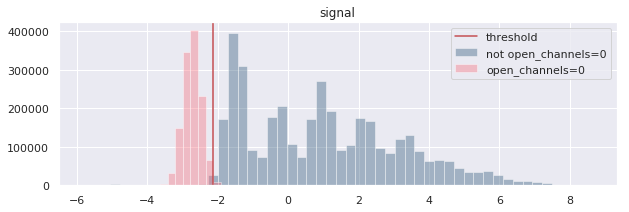

In [24]:
feat = 'signal'
idxs_0 = df_tr['open_channels'] == 0
signal_0 = df_tr['signal'].values[idxs_0]
thre_0 = np.quantile(signal_0, 0.99)
idxs = df_tr['signal'].values[~idxs_0] < thre_0

plt.figure(figsize=(10, 3))
sns.distplot(df_tr[feat].values[~idxs_0], color=cp[4], label='not open_channels=0', kde=False)
sns.distplot(df_tr[feat].values[idxs_0], color=cp[1], label='open_channels=0', kde=False)
plt.axvline(thre_0, color='r', label='threshold')
plt.title(feat)
plt.legend()

print('threshold: ', thre_0)
len(signal_0[signal_0 > thre_0]), len(df_tr[~idxs_0][idxs])

In [27]:
%%time
n_thre = 10
thre_list = np.linspace(-2.716, -2.11, n_thre)
f1_scores = []
for thre_0 in thre_list:
    print(f'thre: {thre_0}, start at {time.ctime()}')
    idxs_thre = df_tr['signal'].values < thre_0
    idxs_thre_te = df_te['signal'].values < thre_0

    _X = X[~idxs_thre]
    _y = y[~idxs_thre]
    _X_te = X_te[~idxs_thre_te]
    test_pred_round, test_pred, oof_round, oof = train_lgbm(_X, _y, _X_te, lgbm_params,
                                                            n_fold=N_FOLD, 
                                                            verbose=0, 
                                                            random_state=KFOLD_SEED, 
                                                            early_stopping_rounds=EARLY_STOPPING_ROUNDS, 
                                                            show_fig=False
                                                           )

    oof_round_mod = np.zeros(len(df_tr)).astype('int8')
    oof_round_mod[~idxs_thre] = oof_round
    print('f1_macro(mod)', f1_macro(df_tr['open_channels'].values, oof_round_mod))
    print('')
    print('')
    score = f1_macro(df_tr['open_channels'].values, oof_round_mod)
    f1_scores.append(score)

thre: -2.716, start at Tue Apr 28 11:32:20 2020
====== finish ======
score list: [0.9367630709607407, 0.937065151105407, 0.9364225029926476, 0.9369770080593692]
CV mean score(f1_macro): 0.9368, std: 0.0002
oof score(f1_macro): 0.9368

f1_macro(mod) 0.9364345462216961


thre: -2.6486666666666667, start at Tue Apr 28 11:49:37 2020
====== finish ======
score list: [0.9369804442409198, 0.9367764786870645, 0.9362201953617795, 0.9369081761591633]
CV mean score(f1_macro): 0.9367, std: 0.0003
oof score(f1_macro): 0.9367

f1_macro(mod) 0.9364332461336347


thre: -2.5813333333333333, start at Tue Apr 28 12:06:25 2020
====== finish ======
score list: [0.9369668384227942, 0.9363807840941875, 0.9359788626664094, 0.9368857357801388]
CV mean score(f1_macro): 0.9366, std: 0.0004
oof score(f1_macro): 0.9366

f1_macro(mod) 0.9363876870816156


thre: -2.5140000000000002, start at Tue Apr 28 12:22:33 2020
====== finish ======
score list: [0.9365805623135327, 0.9366268327909288, 0.935758386523971, 0.936557

Text(0, 0.5, 'f1_score(macro)')

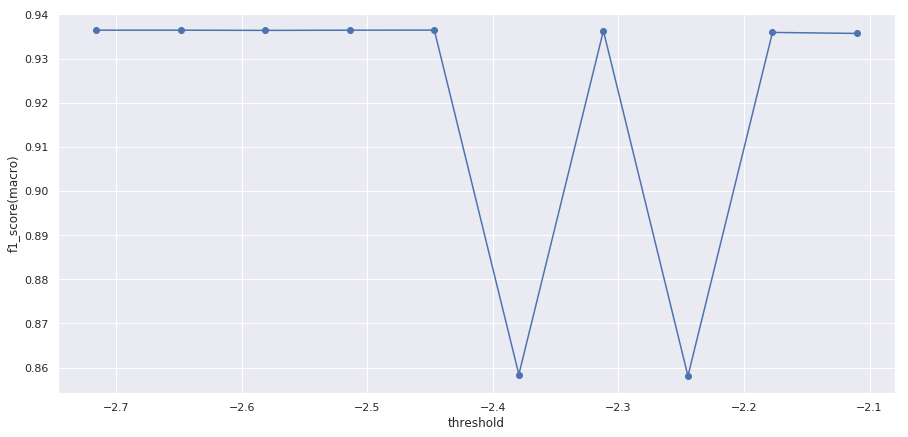

In [28]:
plt.figure(figsize=(15, 7))
plt.plot(thre_list, f1_scores, '-o')
plt.xlabel('threshold')
plt.ylabel('f1_score(macro)')

In [29]:
print(f'best f1_score(macro) {np.max(f1_scores)}')
print(f'best threshold {thre_list[np.argmax(f1_scores)]}')

best f1_score(macro) 0.9364568072805235
best threshold -2.4466666666666668


> あんまりうまくいかなかったっすね